In [93]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
from scipy.stats import norm, norminvgauss, triang
from time import time

In [82]:
############################
#### Physical constants ####
############################
PhysicalConstants = namedtuple('PhysicalConstants', ('g', 'rho_w', 'nu'))
CONST = PhysicalConstants(g=9.81,      # Acceleration due to gravity (m/s**2)
                          rho_w=1.025,  # Density of sea water (kg/m**3)
                          nu=1.358e-6, # Kinematic viscosity of sea water (m**2/s)
                         )

# Density distribution

In [7]:
# Normal-inverse Gaussian distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

loc   = 0.84
scale = 0.097
alpha = 75.1
beta  = 71.3
pdf_density = norminvgauss(alpha, beta, loc, scale)
rvs_density = lambda N: pdf_density.rvs(N)

Text(0, 0.5, 'Probability density')

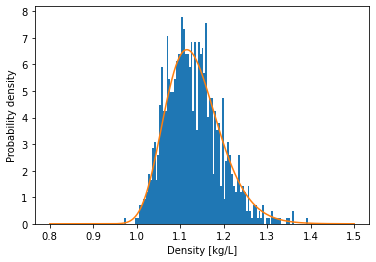

In [10]:
# Plot resulting distribution
rho = np.linspace(0.8, 1.5, 1000)
# Make a random sample and plot histogram
plt.hist(rvs_density(1000), bins=100, density=True)
plt.plot(rho, pdf_density.pdf(rho))
plt.xlabel('Density [kg/L]')
plt.ylabel('Probability density')

# Size distribution

In [16]:
# Power law distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379
# Cut-offs at 20 um and 5000 um.

# Un-normalised number distribution pdf
alpha = 1.6
powerlaw = lambda d : d ** (-alpha)
# Normalisation constant (calculated analytically from the integral)
P0 = 1/(-5/3*(5000**(-0.6) - 20**(-0.6)))
# Normalised volume distribution
pdf_size = lambda d: P0*powerlaw(d)

# Find CDF
F = lambda d: P0*(5/3)*(20**(-0.6) - d**(-0.6))
# Analytical inverse
F_inv = lambda u: (20**(-0.6) - 3*u/(5*P0))**(-5/3)

# Make a function to draw random samples,
# with the same signature as for density
rvs_size = lambda N: F_inv(np.random.random(N))

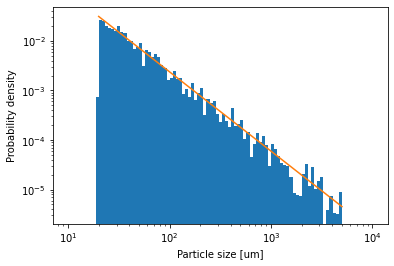

In [21]:
# Plot resulting distribution
size = np.linspace(20, 5000, 1000)
# Make a random sample and plot histogram
plt.hist(rvs_size(1000), bins=np.logspace(1, 4, 100), density=True)
plt.plot(size, pdf_size(size))
plt.xlabel('Particle size [um]')
plt.ylabel('Probability density')
plt.xscale('log')
plt.yscale('log')

# Shape distribution

In [57]:
# Distribution for Corey Shape Factor (CSF)
# total for all particles, included for completeness
# Note that we will actually use separate distributions
# for different shape categories, see below
# Parameters
f1, f2 = 0.06, 0.94
sigma1, sigma2 = 0.03, 0.19
mu1, mu2 = 0.08, 0.44
# Create two Gaussians
rv1 = norm(mu1, sigma1)
rv2 = norm(mu2, sigma2)
# Combine and normalise to compensate for truncation at 0 and 1
shape_distribution = lambda CSF : f1*rv1.pdf(CSF) / (rv1.cdf(1) - rv1.cdf(0)) + f2*rv2.pdf(CSF) / (rv2.cdf(1) - rv2.cdf(0))


# Distribution for Corey Shape Factor (CSF),
# separately for shape categories Fibre, Fragment, Bead, Film, and Foam
# All are symmetric, triangular distributions, with parameters from the supplementary material of
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

# c is a shape parameter, 0.5 = symmetric
c = 0.5
# loc is the leftmost point
# loc + c*scale is the peak
# loc + scale is the rightmost point
fibre_width  = triang(c, loc = 0.001, scale = 0.499)
fibre_height = triang(c, loc = 0.001, scale = 0.499)
fragment_width  = triang(c, loc = 0.1,  scale = 0.9)
fragment_height = triang(c, loc = 0.01, scale = 0.99)
bead_width  = triang(c, loc = 0.6,  scale = 0.4)
bead_height = triang(c, loc = 0.36, scale = 0.64)
film_width  = triang(c, loc = 0.1,   scale = 0.9)
film_height = triang(c, loc = 0.001, scale = 0.099)
foam_width  = triang(c, loc = 0.1,  scale = 0.9)
foam_height = triang(c, loc = 0.01, scale = 0.99)

# Function to generate random samples of shapes
def rvs_shape(N):
    category = np.zeros(N, dtype=np.int32)
    width  = np.zeros(N)
    height = np.zeros(N)
    # Select particle type
    xi = np.random.random(N)
    # Fill array based on value of xi
    # Probabilities are
    # Fibre    : 0.51
    # Fragment : 0.33
    # Bead     : 0.068
    # Film     : 0.056
    # Foam     : 0.036
    limits = np.cumsum([0.0, 0.51, 0.33, 0.068, 0.056, 0.036])
    width_pdfs  = [fibre_width,  fragment_width,  bead_width,  film_width,  foam_width ]
    height_pdfs = [fibre_height, fragment_height, bead_height, film_height, foam_height]
    for i in range(len(limits)-1):
        # Select particles in this category
        mask = (limits[i] <= xi) & (xi < limits[i+1])
        # Track particle type
        category[mask] = i
        # Draw width and height from relevant distribution
        width[mask]  = width_pdfs[i].rvs(np.sum(mask))
        height[mask] = height_pdfs[i].rvs(np.sum(mask))
        
    # Keep track of which particles are fibres
    fibre = xi < limits[1]
    # Make sure that height < width
    mask = width < height
    width[mask], height[mask] = height[mask], width[mask]
    # Calculate CSF (note that dimensions are scaled so that L=1)
    CSF = height / np.sqrt(width)
    return CSF, width, height, category

p(fibre) = 0.51019
p(fragment) = 0.33011
p(bead) = 0.0672
p(film) = 0.05537
p(foam) = 0.03713


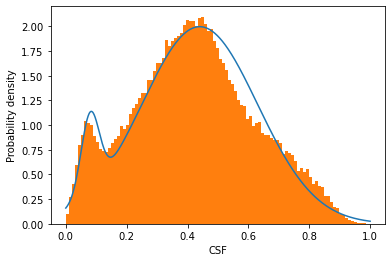

In [103]:
# Plot the complete CSF distribution found by Kooi & Koelsmans
CSF = np.linspace(0, 1, 1000)
plt.plot(CSF, shape_distribution(CSF))

# Make a random sample and plot histogram
CSF, w, h, cat = rvs_shape(100000)
plt.hist(CSF, bins=100, density=True)
plt.xlabel('CSF')
plt.ylabel('Probability density')

# Verify shape category probabilities
for i, shape in enumerate(['fibre', 'fragment', 'bead', 'film', 'foam']):
    print(f'p({shape}) = {np.sum(cat==i)/len(cat)}')


# Rise and settling speeds from Waldschläger & Schüttrumpf (2019)

In [89]:
# Rise speeds are calculated from drag coefficient, C_D
def rise_speed_CD(d, rho, CD):
    g_ = CONST.g*(rho - CONST.rho_w)/CONST.rho_w
    return np.sqrt(4*d*np.abs(g_)/(3*CD)) * np.sign(g_)


# Since C_D is a function of speed, the speed is found by an iterative procedure
def CD_iterator(CD_func, d, rho, CSF, rtol = 1e-6, maxiter = 100, return_speed=False, verbose=False):
    # Drag coefficients are given implicitly as a function of Re.
    # Solve for CD with iterative procedure,
    # start by guessing Re from Stokes' law.
    
    # Initial guess at a Reynolds number from Stokes' law
    Re0 = np.abs(rise_speed_stokes(d, rho)) * d / CONST.nu
    # Iterate until tolerance met, or maxiter
    Re = Re0
    for n in range(maxiter):
        # Calculate drag coefficient
        CD = CD_func(Re, CSF)
        # Calculate new Reynolds number
        Re = np.abs(rise_speed_CD(d, rho, CD)) * d / CONST.nu
        # Check for convergence
        if not np.any(np.abs(Re0 - Re)/Re0 > rtol):
            if verbose:
                print(f'Converged in {n} iterations')
            break
        Re0 = Re
    
    # Return either speed or drag coefficient, depending on kwarg
    if return_speed:
        return rise_speed_CD(d, rho, CD)
    else:
        return CD

def CD_pellet_sinking(Re, CSF):
    # Drag coefficient for sinking pellets from Eq. (10) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 3 / (CSF*Re**(1/3))

def CD_fibre_sinking(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (11) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 4.7/np.sqrt(Re) + np.sqrt(CSF)

def CD_pellet_rising(Re, CSF):
    # Drag coefficient for rising pellets from Eq. (12) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    # Note: Hard-coding the Powers roundness factor to 3.5
    P = 6
    return (20/Re + 10/np.sqrt(Re) + np.sqrt(1.195 - CSF))*(6/P)**(1-CSF)

def CD_fibre_rising(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (13) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 10/np.sqrt(Re) + np.sqrt(CSF)

def CD_stokes(Re, _):
    return 24/Re

In [90]:
# Two other rise speed functions, for comparison
def rise_speed_stokes(d, rho):
    '''
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    
    # Physical constants
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g     = CONST.g     # Acceleration of gravity (m/s**2)
    # reduced gravity
    g_    = g*(rho - rho_w) / rho_w
    # calculate and return velocity (positive upwards)
    return d**2 * g_ / (18*nu)


def rise_speed_johansen(d, rho):
    '''
    Calculate the rise speed (m/s) of a droplet due to buoyancy.
    This scheme uses Stokes' law at small Reynolds numbers, with
    a harmonic transition to a constant drag coefficient at high
    Reynolds numbers.
    
    See Johansen (2000), Eq. (14) for details.
    
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    # Physical constants
    pref  = 1.054       # Numerical prefactor
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g = CONST.g         # Acceleration of gravity (m/s**2)
    
    g_    = g*(rho_w - rho) / rho_w
    w1    = d**2 * g_ / (18*nu)
    w2    = np.sqrt(d*abs(g_)) * pref * np.sign(g_)
    return w1*w2/(w1+w2)

Converged in 17 iterations
1.8639243152478094e-05
Converged in 9 iterations
-0.0015541809587702776
Converged in 0 iterations
-1.566148209346602e-05


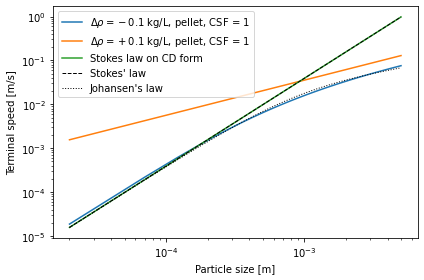

In [91]:
# Compare expression for pellets (using CSF=1) to Stokes' law
d = np.linspace(20e-6, 5e-3, 100)

# Positively buoyant
rho = CONST.rho_w - 0.1 # kg/L
# Get the drag coefficient
CD = CD_iterator(CD_pellet_rising, d, rho, CSF=1, verbose=True)
l = plt.plot(d, -rise_speed_CD(d, rho, CD), label = f'$\Delta \\rho = -0.1$ kg/L, pellet, CSF = 1')
print(-rise_speed_CD(d, rho, CD)[0])

# Negatively buoyant
rho = CONST.rho_w + 0.1 # kg/L
# Get the drag coefficient
CD = CD_iterator(CD_pellet_sinking, d, rho, CSF=1, verbose=True)
l = plt.plot(d, rise_speed_CD(d, rho, CD), label = f'$\Delta \\rho = +0.1$ kg/L, pellet, CSF = 1')
print(-rise_speed_CD(d, rho, CD)[0])

# Stokes' law on drag coefficient form
# Get the drag coefficient
CD = CD_iterator(CD_stokes, d, rho, CSF=1, verbose=True)
l = plt.plot(d, rise_speed_CD(d, rho, CD), label = f'Stokes law on CD form')
print(-rise_speed_CD(d, rho, CD)[0])


plt.plot(d, rise_speed_stokes(d, rho), '--', c = 'k', lw = 1, label = f"Stokes' law")
plt.plot(d, -rise_speed_johansen(d, rho), ':', c = 'k', lw = 1, label = f"Johansen's law")

plt.legend(loc = 'upper left')
plt.xlabel('Particle size [m]')
plt.ylabel('Terminal speed [m/s]')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('speed_comparison.png', dpi = 120)

# Speed distribution

Calculated 10000000 speeds in 9.616 seconds


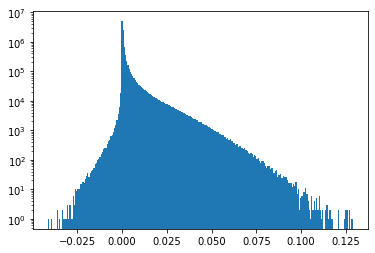

In [95]:
# Number of samples
Np = 10000000

tic = time()

# Density
rho = rvs_density(Np)
# Size (longest dimension)
l = rvs_size(Np) / 1e6
# Shape, and associated parameters
# Note that h_ = h/l and w_ = w/l are normalised height and width
# and we assume h <= w <= l
CSF, w_, h_, cat = rvs_shape(Np)
# Calculate real height and width
h = l*h_
w = l*w_
# calculate equivalent spherical diameter
# (assuming ellipsoid shape)
d = (l*w*h)**(1.0/3)

# Array to hold speeds
v = np.zeros(Np)


# Calculate speeds separately for fibres and other particles
# Note that we use only the "rising" expressions from Waldschläger & Schüttrumpf

# Calculate speed for fibres
v[cat==0] = CD_iterator(CD_fibre_rising, d[cat==0], rho[cat==0], CSF=CSF[cat==0], return_speed=True)
# Calculate speed for fibres
v[cat!=0] = CD_iterator(CD_pellet_rising, d[cat!=0], rho[cat!=0], CSF=CSF[cat!=0], return_speed=True)

toc = time()
print(f'Calculated {Np} speeds in {toc-tic:.3f} seconds')

# Plot histogram of speeds
_ = plt.hist(v, bins=250)
plt.yscale('log')

(0.5098516, 0.330009, 0.0680661, 0.05597, 0.0361033)